# Solving TSP using GA
- Population Size = 10
- Max Generations = 30
- Using Permutation Encoding to represent chromosome solution
- Each Chromosome defined as = ( order of cities ) = ( city1, city2, ...., cityi, ...., cityN )
- Total cities = 5
- Total Genes = 5
- David Crossover Technique as the Crossover Operator
- Scramble Mutation Technique as the Mutation Operator


# Importing Libraries

In [52]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from tqdm.notebook import tqdm as tqdm
from statistics import mean
import time
from ttictoc import tic,toc


# Defining Parameter Values and Constraints

In [53]:
# TSP Parameter Contraints
tot_cities=5

distMatrix = np.array([
                [0,2,5,3,6],
                [2,0,4,3,3],
                [5,4,0,7,3],
                [3,3,7,0,3],
                [6,3,3,3,0]])

# GA Parameters
pop_size = 10    # total Chromosomes/ possible solution in each generation
tot_genes = tot_cities    # total genes/params in each chromosome

elitepop_ctr = int(0.1*pop_size)
if pop_size - elitepop_ctr %2!=0:
    elitepop_ctr+=1

maxGen=30
ProbOfCross=0.8
ProbOfMut=0.1




# Defining Chromosome Class

In [54]:
# Encapsulating all Chromosome Initialization and defining
# Create a possible tour of cities randomly
# Calculate corresponding tour cost
class chromosome:

    def init_chromosome(self):
        self.chromo_str = np.random.permutation(range(1,tot_cities+1)).tolist()
        self.tot_genes=5        

    def set_chromosome(self,chromo_str):
        self.chromo_str = chromo_str

    def cal_tour_cost(self):
        cost=0
        for i in range(0,tot_cities-1):
            cost+=distMatrix[self.chromo_str[i]-1,self.chromo_str[i+1]-1]
        cost+=distMatrix[self.chromo_str[tot_cities-1]-1,self.chromo_str[0]-1]
        self.tour_cost=cost

    def __init__(self,chromo_str=None):
        if chromo_str is None:
            self.init_chromosome()
        else:
            self.set_chromosome(chromo_str)
        self.cal_tour_cost()


# Test Run to create chromosome Object

In [55]:
tic()
chromo1=chromosome()
print(toc())
print(chromo1.chromo_str)
chromo1.tour_cost


0.00013339999986783369
[3, 5, 2, 1, 4]


18

# Crossover and Mutation Functions

In [56]:
def davidCrossover(p1,p2):
    #p1 p2 being permutation encoded strings / sequence 
    point1=np.random.randint(0,tot_genes-1)
    jump=np.random.randint(1,tot_genes-point1)
    point2=point1+jump

    off1=p1[point1:point2+1]
    off2=p2[point1:point2+1]

    p1_i=point2+1
    p2_i=point2+1
    k1=0
    k2=0
    kmax=tot_genes - (point2-point1+1)    
    while k1<kmax or k2<kmax:

        if p1_i % tot_genes == 0:
            p1_i=0
        if p2_i % tot_genes == 0:
            p2_i=0

        if p2[p2_i] not in off1:
            off1.append(p2[p2_i])
            k1+=1

        if p1[p1_i] not in off2:
            off2.append(p1[p1_i])
            k2+=1
        
        p1_i+=1
        p2_i+=1
    
    off1=off1[-point1:]+off1[0:-point1]
    off2=off2[-point1:]+off2[0:-point1]

    off1=chromosome(off1)
    off2=chromosome(off2)
    
    return off1,off2

def scrambleMutation(chromo_str):   
    # chromo_str being permutation encoded string / sequence 
    point1=np.random.randint(0,tot_genes-1)
    jump=np.random.randint(1,tot_genes-point1)
    point2=point1+jump

    scramble_str = np.random.permutation(chromo_str[point1:point2+1]).tolist()
    mut_chromo_str = chromo_str[0:point1] + scramble_str + chromo_str[point2+1:]
    
    return chromosome(mut_chromo_str)


# Generation Class 

In [57]:
# Encapsulating all Generation Operations to create Next Gen
# Sets initial Gen, and declares metric storing variabls
# Logs generation Tour Cost and Calculates fitness
# Gets the best Elite population to forward to the next Gen
# The remaining Gen is selected by choosing parents by random Roulette selection method 
# Applying Crossover and Mutation as per Probability of Crossover and Mutation to produce offsprings
class Generation:

    def __init__(self,curGen):
        self.curGen=curGen
        self.nextGen=[None]*pop_size
        self.gen_cost=np.empty(pop_size)
        self.gen_fitness=np.empty(pop_size)
        self.costLines = {'max':[],'min':[],'mean':[]}
        self.FitnessLines = {'max':[],'min':[],'mean':[]}
        
    def getCurGen(self):
        return self.curGen

    def printCurGen(self):
        print(self.curGen)

    def get_Gen_Cost(self):
        self.gen_cost = np.array([self.curGen[x].tour_cost for x in range(pop_size)])
        
    def get_elite_pop(self):
        elitePop_index = np.argsort(self.gen_cost)[0:elitepop_ctr]
        elitePop = np.array(self.curGen)[elitePop_index.astype('int')]
        return elitePop

    def get_fitness(self):
        invertedCosts = 1/self.gen_cost
        sum = np.sum(invertedCosts)
        self.gen_fitness = (invertedCosts/sum)*100 
        self.cum_gen_fitness = np.cumsum(self.gen_fitness)

    def roulette_wheel(self):
        
        val = np.random.rand()*100 
        p1=np.digitize(val,self.cum_gen_fitness,right=True)

        while True:
            val = np.random.rand()*100 
            p2=np.digitize(val,self.cum_gen_fitness,right=True)

            if p2!=p1:
                break

        return (p1,p2)

    def logMetrics(self):
        self.costLines['max'].append(max(self.gen_cost))
        self.costLines['min'].append(min(self.gen_cost))
        self.costLines['mean'].append(mean(self.gen_cost))

        self.FitnessLines['max'].append(max(self.gen_fitness))
        self.FitnessLines['min'].append(min(self.gen_fitness))
        self.FitnessLines['mean'].append(mean(self.gen_fitness))
        
    def createNextGen(self):
        self.get_Gen_Cost()
        self.get_fitness()
        self.logMetrics()

        nextGen=[None]*pop_size
        nextGen[0:elitepop_ctr] = self.get_elite_pop()
        
        mutFlag1=(np.random.rand(pop_size) < ProbOfMut)
        mutFlag2=(np.random.rand(pop_size) < ProbOfMut)
        crossFlag=(np.random.rand(pop_size) < ProbOfCross)

        i=elitepop_ctr
        while i<pop_size:
            p1,p2 = self.roulette_wheel()
            p1_chromo=self.curGen[p1]
            p2_chromo=self.curGen[p2]    
            
            nextGen[i]=p1_chromo
            nextGen[i+1]=p2_chromo   
            
            if crossFlag[i]:            
                off1,off2 = davidCrossover(p1_chromo.chromo_str,p2_chromo.chromo_str)
                nextGen[i]=off1
                nextGen[i+1]=off2
            if mutFlag1[i]: 
                nextGen[i]=scrambleMutation(nextGen[i].chromo_str)
            if mutFlag2[i]: 
                nextGen[i+1]=scrambleMutation(nextGen[i+1].chromo_str)
            
            #print("%d Done!"%(i+1))
            i+=2
            
        self.curGen = nextGen


# Generating Initial Population

In [60]:
curGen=[None]*pop_size
print("\n No.:     Tour Order    ->  Tour Cost ")
for i in tqdm(range(pop_size),"Chromosomes generated"):
    chromo=chromosome()
    curGen[i]=chromo
    print("\n  %d : "%(i+1),chromo.chromo_str," -> ",chromo.tour_cost)
    


 No.:     Tour Order    -&gt;  Tour Cost 



  1 :  [3, 4, 1, 5, 2]  -&gt;  23

  2 :  [4, 1, 2, 5, 3]  -&gt;  18

  3 :  [5, 1, 4, 3, 2]  -&gt;  23

  4 :  [3, 5, 1, 4, 2]  -&gt;  19

  5 :  [1, 3, 2, 4, 5]  -&gt;  21

  6 :  [2, 4, 5, 1, 3]  -&gt;  21

  7 :  [2, 1, 3, 4, 5]  -&gt;  20

  8 :  [3, 2, 4, 5, 1]  -&gt;  21

  9 :  [2, 3, 4, 5, 1]  -&gt;  22

  10 :  [4, 3, 2, 1, 5]  -&gt;  22



# Creating Further Generations upto MaxGen

In [61]:

Gen=Generation(curGen)
for i in tqdm(range(30),"Generations Completed"):
    #print("\n  Creating Next Gen %d:\n"%(i+1))
    Gen.createNextGen()



# Defining Metrics Plotting Function

In [62]:
def plot_Metrics(i,metricDict,metricName,maxGen,xStep,yStep):
    
    plt.figure(i)
    
    xMaxVal=maxGen+1
    yMaxVal=max(metricDict['max'])+1
    
    plt.xlim(0,xMaxVal)
    plt.ylim(0,yMaxVal)
    
    plt.xticks(np.arange(0,xMaxVal,xStep))
    plt.yticks(np.arange(0,yMaxVal,yStep))
    
    plt.xlabel("Generation No.")
    plt.ylabel(metricName)
    plt.title("Tour %s vs Generation"%(metricName))
    
    maxColor="red"
    minColor="green"
    meanColor="blue"
    
    m1,=plt.plot(metricDict['max'],color=maxColor)
    m2,=plt.plot(metricDict['min'],color=minColor)
    m3,=plt.plot(metricDict['mean'],color=meanColor)
    
    plt.legend([m1,m2,m3],["Max "+metricName,"Min "+metricName,"Average "+metricName],loc="upper right")
    
    return

# Plot Tour Cost, Fitness Accross Generations

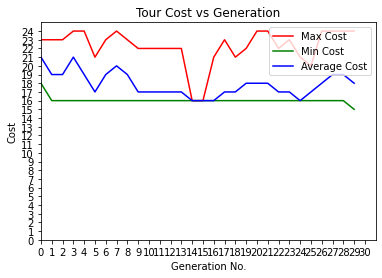

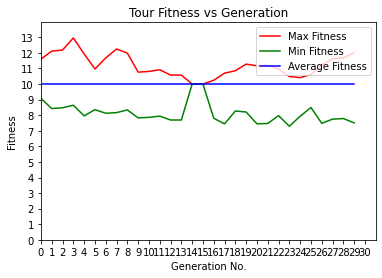

In [63]:
xStep=1
plot_Metrics(0,Gen.costLines,"Cost",maxGen,xStep,1)
plot_Metrics(1,Gen.FitnessLines,"Fitness",maxGen,xStep,1)

plt.show()

# Current Best Gen Solution Parameters

In [64]:
print("Gen Chromo Params")
print("\n No.:     Tour Order    ->  Tour Cost ")
for i in range(pop_size):
    print("\n  %d : "%(i+1),Gen.curGen[i].chromo_str," -> ",Gen.curGen[i].tour_cost)

Gen Chromo Params

 No.:     Tour Order    -&gt;  Tour Cost 

  1 :  [3, 2, 1, 4, 5]  -&gt;  15

  2 :  [3, 1, 2, 4, 5]  -&gt;  16

  3 :  [3, 2, 1, 4, 5]  -&gt;  15

  4 :  [4, 2, 3, 1, 5]  -&gt;  21

  5 :  [4, 1, 5, 3, 2]  -&gt;  19

  6 :  [1, 2, 4, 3, 5]  -&gt;  21

  7 :  [3, 2, 4, 5, 1]  -&gt;  21

  8 :  [1, 2, 4, 5, 3]  -&gt;  16

  9 :  [1, 2, 4, 5, 3]  -&gt;  16

  10 :  [3, 2, 1, 4, 5]  -&gt;  15


# Extracting Best Solution from Current Best Gen

In [65]:
# Last Run Best Solution 
# Min Cost :  15
# Possible Min Cost Tour :  [3, 2, 1, 4, 5]

print("\n Min Cost : ",Gen.curGen[0].tour_cost)
print("\n Possible Min Cost Tour : ", Gen.curGen[0].chromo_str)



 Min Cost :  15

 Possible Min Cost Tour :  [3, 2, 1, 4, 5]


## GA Algo Cross-check by Generating all possible Routes & corresponding Tour Cost

In [66]:
from sympy.utilities.iterables import multiset_permutations

cities = np.array(range(1,tot_cities+1))

print("\n No.:     Tour Order    ->  Tour Cost ")

i=0
min_cost = 100000
min_cost_tour = 100000
for tour in multiset_permutations(cities):
    chromo=chromosome(tour)
    print("\n  %d : "%(i+1),chromo.chromo_str," -> ",chromo.tour_cost)
    if chromo.tour_cost < min_cost:
        min_cost=chromo.tour_cost
        min_cost_tour=chromo.chromo_str
    i+=1

print("\n Min Cost : ",min_cost)
print("\n Possible Min Cost Tour : ", min_cost_tour)


 No.:     Tour Order    -&gt;  Tour Cost 

  1 :  [1, 2, 3, 4, 5]  -&gt;  22

  2 :  [1, 2, 3, 5, 4]  -&gt;  15

  3 :  [1, 2, 4, 3, 5]  -&gt;  21

  4 :  [1, 2, 4, 5, 3]  -&gt;  16

  5 :  [1, 2, 5, 3, 4]  -&gt;  18

  6 :  [1, 2, 5, 4, 3]  -&gt;  20

  7 :  [1, 3, 2, 4, 5]  -&gt;  21

  8 :  [1, 3, 2, 5, 4]  -&gt;  18

  9 :  [1, 3, 4, 2, 5]  -&gt;  24

  10 :  [1, 3, 4, 5, 2]  -&gt;  20

  11 :  [1, 3, 5, 2, 4]  -&gt;  17

  12 :  [1, 3, 5, 4, 2]  -&gt;  16

  13 :  [1, 4, 2, 3, 5]  -&gt;  19

  14 :  [1, 4, 2, 5, 3]  -&gt;  17

  15 :  [1, 4, 3, 2, 5]  -&gt;  23

  16 :  [1, 4, 3, 5, 2]  -&gt;  18

  17 :  [1, 4, 5, 2, 3]  -&gt;  18

  18 :  [1, 4, 5, 3, 2]  -&gt;  15

  19 :  [1, 5, 2, 3, 4]  -&gt;  23

  20 :  [1, 5, 2, 4, 3]  -&gt;  24

  21 :  [1, 5, 3, 2, 4]  -&gt;  19

  22 :  [1, 5, 3, 4, 2]  -&gt;  21

  23 :  [1, 5, 4, 2, 3]  -&gt;  21

  24 :  [1, 5, 4, 3, 2]  -&gt;  22

  25 :  [2, 1, 3, 4, 5]  -&gt;  20

  26 :  [2, 1, 3, 5, 4]  -&gt;  16

  27 :  [2, 1, 4, 3, 5]  -&gt